In [ ]:
import os
import pathlib
import re
import collections
import scipy.spatial.distance as ds
import pickle
import numpy as np
import random
import string
from string import digits
import pandas as pd
import unicodedata
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

import matplotlib.ticker as ticker
from nltk.translate.bleu_score import sentence_bleu
from __future__ import absolute_import, division, print_function
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)
import io
import time
from sklearn.model_selection import train_test_split

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.8.2


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!tar -xvf  "/content/drive/My Drive/Adv_NLP_Project/dakshina_dataset_v1.0.tar" -C "/content/sample_data/" 
# !tar -xvf  "/content/drive/MyDrive/NLP/Project/Dataset/dakshina_dataset_v1.0.tar" -C "/content/sample_data/"

dakshina_dataset_v1.0/bn/
dakshina_dataset_v1.0/bn/lexicons/
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.dev.tsv
dakshina_dataset_v1.0/bn/native_script_wikipedia/
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.valid.text.shuf.txt.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.info.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.info.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.text.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.text.shuf.txt.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.nonblock.sections.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.omit_pages.txt.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.text.sorted.tsv.gz
dakshina_dataset_v1.0/bn/na

In [ ]:
l_train = []
l_test = []

f1="/content/sample_data/dakshina_dataset_v1.0/hi/romanized/hi.romanized.rejoined.dev.native.txt"
curr_file1 = open(f1, "r")
for line in curr_file1:
  temp = []
  temp.append(line)
  l_train.append(temp)
curr_file1.close()

f2="/content/sample_data/dakshina_dataset_v1.0/hi/romanized/hi.romanized.rejoined.dev.roman.txt"
curr_file2 = open(f2, "r")
i=0
for line in curr_file2:
  l_train[i].append(line)
  i+=1
curr_file2.close()

f3="/content/sample_data/dakshina_dataset_v1.0/hi/romanized/hi.romanized.rejoined.test.native.txt"
curr_file3 = open(f3, "r")
for line in curr_file3:
  temp = []
  temp.append(line)
  l_test.append(temp)
curr_file1.close()

f4="/content/sample_data/dakshina_dataset_v1.0/hi/romanized/hi.romanized.rejoined.test.roman.txt"
curr_file4 = open(f4, "r")
i=0
for line in curr_file4:
  l_test[i].append(line)
  i+=1
curr_file2.close()

In [ ]:
print(l_train[:10])
print(l_test[:10])

[['इसके आने से पूर्व ही लोग घरों की सफाई का कार्य शुरू कर देते हैं।\n', 'iske aane se purva hi log gharon ki safai ka karya shuru kar dete hain.\n'], ['विलुप्ति की कगार पर गुणकारी तीखुर\n', 'vilupti ki kagaar par gunkaari tikhur\n'], ['माइकल कामेन (द वॉल के वाद्यमय हिस्सों के लिए एक योगदानकर्ता) ने दोनों के बीच मध्यस्थता की और उस भूमिका को निभाया जिस पर पारंपरिक रूप से रिचर्ड राइट ने कब्जा किया हुआ था जो अब अनुपस्थित थे।\n', 'Michael kamen (the wall ke vadyamaya hisso ke liye ek yogdanakarta) ne dono ke bich madhyasthata ki aur us bhumika ko nibhaya jis par paramparik rup se richard wright ne kabja kiya hua tha jo ab anupasthit the.\n'], ['शाहनामा नौरोज़ के त्यौहार को महान जमशेद के शासनकाल से जोड़ता है।\n', 'shahnama noroj ke tyohaar ko mahaan Jamshed ke shashankaal se jodta hai.\n'], ['मेहरोत्रा, डॉ॰ एन.\n', 'Mehrotra, Dr॰ N.\n'], ['दुर्गा भाभी\n', 'durga bhabhi\n'], ['स्वामी बृहस्पति\n', 'swami brhaspati\n'], ['बॉलीवुड, हिन्दी चलचित्र उद्योग भी मुंबई में ही स्थित है।\n', 'bollywood, 

In [ ]:
df = pd.DataFrame(l_train, columns = ['native', 'roman'])
df

,native,roman
0,इसके आने से पूर्व ही लोग घरों की सफाई का कार्य...,iske aane se purva hi log gharon ki safai ka k...
1,विलुप्ति की कगार पर गुणकारी तीखुर\n,vilupti ki kagaar par gunkaari tikhur\n
2,माइकल कामेन (द वॉल के वाद्यमय हिस्सों के लिए ए...,Michael kamen (the wall ke vadyamaya hisso ke ...
3,शाहनामा नौरोज़ के त्यौहार को महान जमशेद के शास...,shahnama noroj ke tyohaar ko mahaan Jamshed ke...
4,"मेहरोत्रा, डॉ॰ एन.\n","Mehrotra, Dr॰ N.\n"
...,...,...
4995,किन्तु लगता है कि यह मलयालम युक्तिभाषा के बाद ...,kintu lagata hai ki yaha malayalama yuktibhasa...
4996,अक्षांश\n,akshansh\n
4997,"वह लापरवाही से एनामारिया, डेवी जोन्स और अन्य स...","vah laparvahi se enamaria, devi jons aur anya ..."
4998,"""मैं सोचती हूँ कि असली वजह यह थी कि निर्देशक ज...","""main sochti hun ki asli vajah yah thi ki nird..."


In [ ]:
letters_native = [chr(letter) for letter in range(2304, 2432)]
alphabet_size_native = len(letters_native)

letter2ind_native = {'<start>': 0,'<end>' : 1}
for index, letter in enumerate(letters_native):
    letter2ind_native[letter] = index+1

print(letter2ind_native)

{'<start>': 0, '<end>': 1, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '

In [ ]:
def preprocess_sentence_roman(w):
    w = w.lower().strip()
    ww = ''
    # Remove all punctuations from the text
    ww += ''.join(ch for ch in w if ch not in string.punctuation)
    # Remove all numbers from text
    remove_digits = str.maketrans('', '', digits)
    ww = ww.translate(remove_digits)
    ww = ww.rstrip().strip()
    # Adding start and end tags
    ww = '@' + ww + '#'
    return ww

def preprocess_sentence_native(w):
    w = w.lower()
    cleaned_line = ''
    # Remove all punctuations from the text
    cleaned_line += ''.join(ch for ch in w if ch not in string.punctuation)
    # Remove all numbers from text
    remove_digits = str.maketrans('', '', digits)
    cleaned_line = cleaned_line.translate(remove_digits)
    cleaned_line = re.sub("[२३०८१५७९४६।–]", "", cleaned_line)
    cleaned_line = cleaned_line.rstrip().strip()
    # Adding start and end tags
    cleaned_line = '@' + cleaned_line + '#'
    return cleaned_line

In [ ]:
def create_dataset(l):
  native_words, native_sents = [], []
  roman_words, roman_sents = [], []

  for i in range(len(df)):
    l[i][0] = preprocess_sentence_native(l[i][0]) # clean native words.
    wordlist1 = l[i][0].split()

    l[i][1] = preprocess_sentence_roman(l[i][1]) # clean roman sentences.
    wordlist2 = l[i][1].split() # clean roman words.

    if len(wordlist1) != len(wordlist2):
      print('Skipping: ',len(wordlist1),len(wordlist2), l[i][0], ' - ', l[i][1])
      continue

    native_words.extend(wordlist1)
    roman_words.extend(wordlist2)

    native_sents.append(wordlist1)
    roman_sents.append(wordlist2)
    
  return [roman_words,native_words], [roman_sents, native_sents]

In [ ]:
train_data, train_sents = create_dataset(l_train)
test_data, test_sents = create_dataset(l_test)

In [ ]:
train_data[0][:10],train_data[1][:10]

(['@iske', 'aane', 'se', 'purva', 'hi', 'log', 'gharon', 'ki', 'safai', 'ka'],
 ['@इसके', 'आने', 'से', 'पूर्व', 'ही', 'लोग', 'घरों', 'की', 'सफाई', 'का'])

In [ ]:
test_data[0][:10],test_data[1][:10]

(['@kumbh',
  'rashi',
  'men',
  'janme',
  'log',
  'sambhavnaon',
  'se',
  'bhari',
  'ek',
  'jagah'],
 ['@कुंभ',
  'राशि',
  'में',
  'जन्मे',
  'लोग',
  'संभावनाओं',
  'से',
  'भरी',
  'एक',
  'जगह'])

In [ ]:
len(test_data[0]),len(test_data[1]),len(train_data[0]),len(train_data[1])

(85161, 85161, 86526, 86526)

Combine the test and train data. So that we can split train and test set according to our needs.

In [ ]:
train_data[0].extend(test_data[0])
train_data[1].extend(test_data[1])

print(len(train_data[0]),len(train_data[1]))

171687 171687


In [ ]:
train_data[0][-1],train_data[1][-1]

('malhotra#', 'मल्होत्रा#')

In [ ]:
len(train_data[0]),len(train_data[1])

(171687, 171687)

In [ ]:
# storing word2index and index2word mappings for both language.
class WordIndex():
  def __init__(self, lang):
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    for phrase in self.lang:
      for l in phrase:
        self.vocab.update(l)
    
    self.vocab = sorted(self.vocab)
    
    self.word2idx['<pad>'] = 0
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word

Helper functions to create Lang vocab and tensors from words.

In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)

def load_dataset(pairs):

    # index language using the class defined above    
    inp_lang = WordIndex(pairs[0])
    targ_lang = WordIndex(pairs[1])
    
    # Vectorize the input and target languages
    
    # words in roman (eng)
    input_tensor = [[inp_lang.word2idx[s] for s in en] for en in pairs[0]]
    
    # words in native (hin)
    target_tensor = [[targ_lang.word2idx[s] for s in hn] for hn in pairs[1]]
    
    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [ ]:
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(train_data)

In [ ]:
print(len(input_tensor),len(target_tensor))

171687 171687


Function to convert tensor to word and print.

In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.idx2word[t]))

In [ ]:
convert(inp_lang,input_tensor[-1])
convert(targ_lang,target_tensor[-1])

15 ----> m
3 ----> a
14 ----> l
10 ----> h
17 ----> o
22 ----> t
20 ----> r
3 ----> a
1 ----> #
70 ----> म
73 ----> ल
96 ----> ्
80 ----> ह
94 ----> ो
60 ----> त
96 ----> ्
72 ----> र
82 ----> ा
1 ----> #


Train and Test split.

In [ ]:
input_tensor = input_tensor[:200000]
target_tensor = target_tensor[:200000]
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.25)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(128765, 128765, 42922, 42922)

Some hyper-parameters.

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 256
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
val_steps_per_epoch = len(input_tensor_val)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)+1
vocab_tar_size = len(targ_lang.word2idx)+1

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([256, 35]), TensorShape([256, 32]))

Let's build the model.
The encoder : it will consume input and produce a thought vector which will be the input of the decoder.

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.norm = tf.keras.layers.LayerNormalization()
    self.layer = tf.keras.layers.Dropout(.1)
    self.LSTM = tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                   trainable=True)

  def call(self, x):
    embedding = self.embedding(x)
    outputs, hidden, cell = self.LSTM(embedding)
    return hidden, cell



In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden, sample_cell = encoder(example_input_batch)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_cell.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (256, 1024)
Encoder Hidden state shape: (batch size, units) (256, 1024)


The decoder : calculates the probablity of next character by taking encoder input.

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.layer = tf.keras.layers.Dropout(.1)
    self.norm = tf.keras.layers.LayerNormalization()
    self.LSTM = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform', trainable=True)
    #self.relu = tf.keras.activations.relu(x, alpha=0.0, max_value=None, threshold=0.0)

  def call(self, x, hid_state, cell):

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.layer(self.embedding(x))
    #print(x.shape, self.dec_units, hid_state.shape)
    encoder_test_states = [hid_state, cell]
    output, state, cell = self.LSTM(x, initial_state=encoder_test_states)
    #print(cell.shape)
    prediction = self.fc(output)
    return prediction, state, cell

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
print(sample_hidden.shape, sample_cell.shape)
sample_decoder_output, _, _ = decoder(tf.random.uniform((256, 1)), sample_hidden, sample_cell)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

(256, 1024) (256, 1024)
Decoder output shape: (batch_size, vocab size) (256, 1, 111)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
loss_object = tf.keras.losses.CategoricalCrossentropy( from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

Adding checkpoints to store the model.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

Training step function.

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
loss_object = tf.keras.losses.SparseCategoricalCrossentropy( from_logits=True, reduction='none')

In [ ]:
@tf.function
def train_step(inp, targ):
  loss = 0

  with tf.GradientTape() as tape:
    state, cell = encoder(inp)

    dec_state = state

    dec_input = tf.expand_dims([targ_lang.word2idx['@']] * BATCH_SIZE, 1)
    outputs = []
    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_state, cell = decoder(dec_input, dec_state, cell)
      outputs.append(predictions)

      #loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

    outputs = tf.stack(outputs)
    outputs = tf.squeeze(outputs,2)
    outputs = tf.transpose(outputs, [1,0,2])
    temp_targ = targ[:,1:targ.shape[1]]
    temp_targ = tf.expand_dims(temp_targ, axis=2)
    loss = loss_object(temp_targ, outputs)
  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
@tf.function
def val_step(inp, targ):
    loss = 0
    state, cell = encoder(inp)

    dec_state = state

    dec_input = tf.expand_dims([targ_lang.word2idx['@']] * BATCH_SIZE, 1)
    outputs = []
    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
        # passing enc_output to the decoder
        predictions, dec_state, cell = decoder(dec_input, dec_state, cell)
        outputs.append(predictions)

        #loss += loss_function(targ[:, t], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)

    outputs = tf.stack(outputs)
    outputs = tf.squeeze(outputs,2)
    outputs = tf.transpose(outputs, [1,0,2])
    temp_targ = targ[:,1:targ.shape[1]]
    temp_targ = tf.expand_dims(temp_targ, axis=2)
    loss = loss_object(temp_targ, outputs)
    batch_loss = (loss / int(targ.shape[1]))

    return batch_loss

In [ ]:
print(len(dataset.take(steps_per_epoch)))

502


Training loop

In [ ]:
EPOCHS = 20
loss_values = []
val_loss_values = []

for epoch in range(EPOCHS):
    start = time.time()

    #enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    val_total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ)
        total_loss += batch_loss

    for (batch, (inp, targ)) in enumerate(val_dataset.take(val_steps_per_epoch)):
        val_batch_loss = val_step(inp, targ)
        val_total_loss += val_batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
  
    ep_loss = total_loss/steps_per_epoch
    loss_values.append( tf.math.reduce_sum(ep_loss))
    val_ep_loss = val_total_loss/val_steps_per_epoch
    val_loss_values.append( tf.math.reduce_sum(val_ep_loss))

    print('Epoch {} Train Loss {:.4f} Val Loss {:.4f}'.format(epoch + 1, tf.math.reduce_sum(ep_loss),tf.math.reduce_sum(val_ep_loss)))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Train Loss 96.9690 Val Loss 60.4248
Time taken for 1 epoch 120.95763564109802 sec

Epoch 2 Train Loss 43.3567 Val Loss 31.6314
Time taken for 1 epoch 73.93144035339355 sec

Epoch 3 Train Loss 27.3767 Val Loss 22.9490
Time taken for 1 epoch 74.40323233604431 sec

Epoch 4 Train Loss 18.9507 Val Loss 17.4256
Time taken for 1 epoch 73.60092496871948 sec

Epoch 5 Train Loss 15.4020 Val Loss 15.9614
Time taken for 1 epoch 73.47367858886719 sec

Epoch 6 Train Loss 13.6502 Val Loss 14.9053
Time taken for 1 epoch 90.65378403663635 sec

Epoch 7 Train Loss 14.9179 Val Loss 16.4195
Time taken for 1 epoch 73.12399697303772 sec

Epoch 8 Train Loss 12.9513 Val Loss 14.5743
Time taken for 1 epoch 73.22854948043823 sec

Epoch 9 Train Loss 11.3976 Val Loss 14.2640
Time taken for 1 epoch 73.25263833999634 sec

Epoch 10 Train Loss 10.7591 Val Loss 14.2039
Time taken for 1 epoch 73.27109932899475 sec

Epoch 11 Train Loss 10.4483 Val Loss 14.3572
Time taken for 1 epoch 73.21956896781921 sec

Epoch 1

In [ ]:
print(tf.math.reduce_sum(ep_loss))

tf.Tensor(11.6545, shape=(), dtype=float32)


In [ ]:
fin_loss_values = []
for i in loss_values :
    print( tf.math.reduce_sum(i))
    fin_loss_values.append( tf.math.reduce_sum(i))

tf.Tensor(96.968994, shape=(), dtype=float32)
tf.Tensor(43.356712, shape=(), dtype=float32)
tf.Tensor(27.376654, shape=(), dtype=float32)
tf.Tensor(18.950748, shape=(), dtype=float32)
tf.Tensor(15.402004, shape=(), dtype=float32)
tf.Tensor(13.65018, shape=(), dtype=float32)
tf.Tensor(14.917943, shape=(), dtype=float32)
tf.Tensor(12.95125, shape=(), dtype=float32)
tf.Tensor(11.397608, shape=(), dtype=float32)
tf.Tensor(10.759108, shape=(), dtype=float32)
tf.Tensor(10.44828, shape=(), dtype=float32)
tf.Tensor(10.484119, shape=(), dtype=float32)
tf.Tensor(10.734845, shape=(), dtype=float32)
tf.Tensor(10.675463, shape=(), dtype=float32)
tf.Tensor(11.003789, shape=(), dtype=float32)
tf.Tensor(11.311649, shape=(), dtype=float32)
tf.Tensor(11.368008, shape=(), dtype=float32)
tf.Tensor(11.597017, shape=(), dtype=float32)
tf.Tensor(11.680117, shape=(), dtype=float32)
tf.Tensor(11.6545, shape=(), dtype=float32)


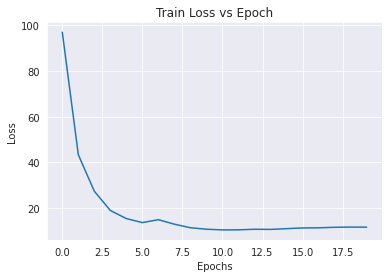

In [ ]:
plt.plot(fin_loss_values)
plt.title('Train Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
fin_val_loss_values = []
for i in val_loss_values :
    print( tf.math.reduce_sum(i))
    fin_val_loss_values.append( tf.math.reduce_sum(i))

tf.Tensor(60.42482, shape=(), dtype=float32)
tf.Tensor(31.631393, shape=(), dtype=float32)
tf.Tensor(22.94899, shape=(), dtype=float32)
tf.Tensor(17.425598, shape=(), dtype=float32)
tf.Tensor(15.961404, shape=(), dtype=float32)
tf.Tensor(14.905256, shape=(), dtype=float32)
tf.Tensor(16.419493, shape=(), dtype=float32)
tf.Tensor(14.574288, shape=(), dtype=float32)
tf.Tensor(14.263995, shape=(), dtype=float32)
tf.Tensor(14.203857, shape=(), dtype=float32)
tf.Tensor(14.357189, shape=(), dtype=float32)
tf.Tensor(14.539952, shape=(), dtype=float32)
tf.Tensor(14.434572, shape=(), dtype=float32)
tf.Tensor(14.78096, shape=(), dtype=float32)
tf.Tensor(15.390099, shape=(), dtype=float32)
tf.Tensor(15.597368, shape=(), dtype=float32)
tf.Tensor(15.271418, shape=(), dtype=float32)
tf.Tensor(15.487928, shape=(), dtype=float32)
tf.Tensor(15.374981, shape=(), dtype=float32)
tf.Tensor(15.695559, shape=(), dtype=float32)


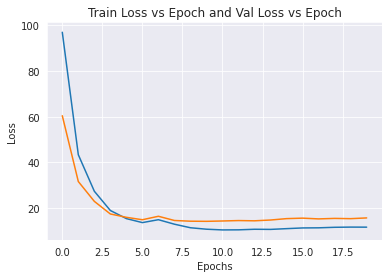

In [ ]:
plt.plot(fin_loss_values)
plt.plot(fin_val_loss_values)
plt.title('Train Loss vs Epoch and Val Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
!zip -r /content/checkpoints.zip /content/training_checkpoints

  adding: content/training_checkpoints/ (stored 0%)
  adding: content/training_checkpoints/ckpt-9.data-00000-of-00001 (deflated 7%)
  adding: content/training_checkpoints/ckpt-4.data-00000-of-00001 (deflated 7%)
  adding: content/training_checkpoints/ckpt-2.data-00000-of-00001 (deflated 7%)
  adding: content/training_checkpoints/ckpt-9.index (deflated 55%)
  adding: content/training_checkpoints/ckpt-7.data-00000-of-00001 (deflated 7%)
  adding: content/training_checkpoints/ckpt-1.index (deflated 55%)
  adding: content/training_checkpoints/ckpt-4.index (deflated 55%)
  adding: content/training_checkpoints/ckpt-3.data-00000-of-00001 (deflated 7%)
  adding: content/training_checkpoints/ckpt-10.data-00000-of-00001 (deflated 7%)
  adding: content/training_checkpoints/ckpt-6.index (deflated 55%)
  adding: content/training_checkpoints/ckpt-2.index (deflated 55%)
  adding: content/training_checkpoints/ckpt-3.index (deflated 55%)
  adding: content/training_checkpoints/ckpt-8.index (deflated 55%

In [ ]:
# !cp -r training_checkpoints /content/drive/MyDrive/NLP/Project/outputs/
!cp -r checkpoints.zip /content/drive/MyDrive/Adv_NLP_Project/

### Evaluation

In [ ]:
def evaluate(sentence):
    #attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence_native(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence]

    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    enc_states, cells = encoder(inputs)

    dec_states = enc_states
    dec_input = tf.expand_dims([targ_lang.word2idx['@']], 0)

    for t in range(max_length_targ):
        predictions, dec_states, cells = decoder(dec_input, dec_states, cells)
        #print("pred :", predictions.shape)
        predicted_id = tf.argmax(predictions[0][0]).numpy()
        #print("pd :", predicted_id.shape)

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '#':
            return result, sentence

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence

In [ ]:
def transliterate(sentence):
    # print("Input: ", sentence)
    all_words = sentence.split()
    final_result = ""
    for word in all_words:
        result, word = evaluate(word)
        temp = "".join(result.split(" "))+" "
        temp = temp.replace("<pad>", "")
        final_result+=temp
    # print("Output: ", final_result)
    return final_result

In [ ]:
from tqdm.notebook import tqdm

def calc_accuracy(test_data, n):
    correct = 0
    for i in tqdm(range(len(test_data[0][:n]))):
        hindi, eng = test_data[0][i], test_data[1][i]

        res, _ = evaluate(hindi)
        res = ''.join(res.split(' '))

        # print(res,eng)
        
        eng = eng.replace("@", "")
        eng = eng.replace("#", "")
        res = res.replace("@", "")
        res = res.replace("#", "")

        # print(eng, res)
        if eng == res:
            # print("Yes\n")
            correct += 1

    # accuracy = correct / len(test_data[0])
    accuracy = correct / n
    return accuracy

In [ ]:
acc = calc_accuracy(test_data, 10)
print("Accuracy on 10 test words:", acc, "\n")

acc = calc_accuracy(test_data, 100)
print("Accuracy on 100 test words:", acc, "\n")

acc = calc_accuracy(test_data, 500)
print("Accuracy on 500 test words:", acc, "\n")

acc = calc_accuracy(test_data, 1000)
print("Accuracy on 1000 test words:", acc, "\n")

acc = calc_accuracy(test_data, 5000)
print("Accuracy on 5000 test words:", acc, "\n")

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on 10 test words: 0.2 



  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on 100 test words: 0.25 



  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy on 500 test words: 0.244 



  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy on 1000 test words: 0.263 



  0%|          | 0/5000 [00:00<?, ?it/s]

Accuracy on 5000 test words: 0.2536 



In [ ]:
from nltk.translate.bleu_score import SmoothingFunction

def calc_bleu(test_sens, n):
    blue_score = 0

    for i in range(len(test_sens[0][:n])):
        inp_sent, trg_sent = test_sens[0][i], test_sens[1][i]

        res = ""
        for i in inp_sent:
            res += i+" "
        res = transliterate(res)

        tmp = ""
        for i in trg_sent:
            tmp += i+" "
        trg_sent = tmp
        trg_sent = trg_sent.replace("@", "")
        trg_sent = trg_sent.replace("#", "")
        res = res.replace("@", "")
        res = res.replace("#", "")

        reference = [trg_sent.split()]
        candidate = res.split()

        smoothie = SmoothingFunction().method4
        blue_score += sentence_bleu(reference, candidate, smoothing_function=smoothie)
    
    if (len(test_sens[0][:n])!=0):
        return blue_score / len(test_sens[0][:n])

In [ ]:
bleu = calc_bleu(test_sents, 1000)
print("Bleu score on 1000 test sentences:", bleu, "\n")

Bleu score on 1000 test sentences: 0.18506658724406877 



### Testing on various input words


In [ ]:
transliterate('how')

Input:  how
Output:  ूव# 


'ूव# '

In [ ]:
transliterate('market')

Input:  market
Output:  मार्केट# 


'मार्केट# '

In [ ]:
transliterate('what')

Input:  what
Output:  वाट# 


'वाट# '

In [ ]:
transliterate('stupid')

Input:  stupid
Output:  स्टीर# 


'स्टीर# '

In [ ]:
transliterate('kumbh')

Input:  kumbh
Output:  मुच्बी 


'मुच्बी '

In [ ]:
transliterate('raasi')

Input:  raasi
Output:  रासाई# 


'रासाई# '

In [ ]:
transliterate('janme')

Input:  janme
Output:  जनीन 


'जनीन '

In [ ]:
transliterate('log')

Input:  log
Output:  लॉग# 


'लॉग# '

In [ ]:
transliterate("what are you doing") 
print()
transliterate("tell me more about yourself")
print()
transliterate("go to walk")
print()
transliterate("this is india")
print()
transliterate("did you have breakfast")

Input:  what are you doing
Output:  वाट# रे# ौबीएन धूंदगी 

Input:  tell me more about yourself
Output:  तेल# में# ूरबन# अबोटिप ॉकीचस्कृत 

Input:  go to walk
Output:  घों टोू# ्युल# 

Input:  this is india
Output:  ठिस# इस# इन्दि 

Input:  did you have breakfast
Output:  दिड# ौबीएन हवीं ्र्टीफ़ेक्चाट्स 


'दिड# ौबीएन हवीं ्र्टीफ़ेक्चाट्स '

In [ ]:
transliterate("bogra ka yudh bharat paak yudh १९७१ ka bhag tha jo vartaman bangladesh mein hua tha") 
print()
transliterate("taruna nirankari  richa sharma jaya ki dusri badi bahan")
print()
transliterate("teen varsh se bacchhon ki bhasha ka vikaas hota hai")
print()
transliterate("lili patel  savitri devi jaya ki nani")
print()
transliterate("ismen bbq sauce jodkar germany mein sthayi rup se beja chata hai")

Input:  bogra ka yudh bharat paak yudh १९७१ ka bhag tha jo vartaman bangladesh mein hua tha
Output:  भोग्रा# का# ्यौढ़ भरा# पका# ्यौढ़ े का# भग# था# ूज़ो# वैरवाता बंग्लीशियन में# ूहा# था# 

Input:  taruna nirankari  richa sharma jaya ki dusri badi bahan
Output:  तुराना# निर्दन# रिचार शर्मा# जय# कीं# दूसरी# बीं# बाहान# 

Input:  teen varsh se bacchhon ki bhasha ka vikaas hota hai
Output:  टीन# वर्ष# शे बच्चों# कीं# भाष# का# ्कींस# ूठिया हि# 

Input:  lili patel  savitri devi jaya ki nani
Output:  लिल# पेटेल# सरित्वी# देवी# जय# कीं# ननी# 

Input:  ismen bbq sauce jodkar germany mein sthayi rup se beja chata hai
Output:  इसमें ब्लै# सुचेर झोड़कर# ्लियंन्कर में# थली# रुप# शे बेज# क्‍ता# हि# 


'इसमें ब्लै# सुचेर झोड़कर# ्लियंन्कर में# थली# रुप# शे बेज# क्\u200dता# हि# '

In [ ]:
result=[]
for i in range(len(l_test)):
    if(i==100):
        break
    output = transliterate(l_test[i][1])
    temp = [l_test[i][1],output,l_test[i][0]]
    result.append(temp)

In [ ]:
res = pd.DataFrame(result, columns = ['input', 'output', 'expected'])
res

,input,output,expected
0,@kumbh rashi men janme log sambhavnaon se bhar...,मुच्बी राशि# में# जनीन लॉग# संश्कालयन# शे भारा...,@कुंभ राशि में जन्मे लोग संभावनाओं से भरी एक ज...
1,@iska ulat bhi satya hai#,इसका# उतल# भी# स्ताय# हि#,@इसका उलट भी सत्य है#
2,@kuch devta jo mukhyatah nagar devta the apne ...,चूं# देवता# ूज़ो# ्युलफ़ीचात# नागारा# देवता# त...,@कुछ देवता जो मुख्यत नगर देवता थे अपने संप्रदा...
3,@tel ke utpadan men sansar men romania ka chha...,तेर# के# उत्पर# में# संसार# में# ्रोमैन# का# छ...,@तेल के उत्पादन में संसार में रोमानिया का छठा ...
4,@banarasi lal se milkar police ne sara bhed pr...,बनारीशार ला# शे मिलाव# ्लोपियन# णी# शपर बीद# प...,@बनारसी लाल से मिलकर पुलिस ने सारा भेद प्राप्त...
...,...,...,...
95,@jiske karan hrdapeshivikriti ya atalata ho sa...,जिकार्ड कनार# हृद्वास्पेवस्थ# यह अतला# ूह# सक्...,@जिसके कारण हृदपेशीविकृति या अतालता हो सकती है#
96,@uttar pradesh vidhan sabha chunav men inhone ...,उत्तर# प्रादेशों ीड़ेना# शभा चुनाविक में# इन्ह...,@उत्तर प्रदेश विधान सभा चुनाव में इन्होंने उत्...
97,@nepali upanyas ka shadharhu nepali bhasha ke ...,नीपुल# उपन्यास# का# सरधार# नीपुल# भाष# के# ्या...,@नेपाली उपन्यास का आधारहरू नेपाली भाषा के विख्...
98,@lekin maghi sahityetihaskaron ke anusar maghi...,लेकिन# मगही# शाहज़िताग्रणकार्यों के# णुसार# मग...,@लेकिन मगही साहित्येतिहासकारों के अनुसार मगही ...


In [ ]:
res.to_csv('file1.csv')